In [2]:
!pip3 install tfa-nightly
#importacion de librerias
import numpy as np
import pandas as pd
import tensorflow as tf
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import *
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG16
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import time
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2
from PIL import Image
import os
import PIL
import glob
from io import BytesIO
import timeit
import os
import warnings
import statistics
# warnings.filterwarnings('ignore')
# from tensorflow.python.keras.applications.efficientnet import EfficientNetB0
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))
print(tf.test.is_gpu_available())
# tf.config.experimental.set_memory_growth = True
# %cd /home/fundamentia/Dropbox/Master/Asignaturas/Deep Learning/PRA1/archive/practica_DL_UOC_2022
def freeze_layers(model):
    for i in model.layers:
        i.trainable = False
        if isinstance(i, Model):
            freeze_layers(i)
    return model


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2.9.2
[]
False


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/TFM/VGG16_models/
%cp -r /content/drive/MyDrive/TFM/Fold* /content/

/content/drive/MyDrive/TFM/VGG16_models


In [ ]:
# cargamos el data set del fold 0
def create_dataset(img_folder):
   
    img_data_array = []
    class_name = []
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path = os.path.join(img_folder, dir1,  file)
            image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
#             image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
#             image = np.array(image)
#             image = image.astype('float32')
#             image /= 255 
            img_data_array.append(image)
            if "Mass" in dir1:
                class_name.append(1)
            else:
                class_name.append(0)
    return np.array(img_data_array), np.array(class_name)

labels = ["normal", "abnormal"]
fold0_test_x, fold0_test_y = create_dataset('Fold0/Test')
fold0_train_x, fold0_train_y = create_dataset('Fold0/Train')
fold0_valid_x, fold0_valid_y = create_dataset('Fold0/Valid')

fold0_test_y_norm = to_categorical(fold0_test_y)
fold0_train_y_norm = to_categorical(fold0_train_y)
fold0_valid_y_norm = to_categorical(fold0_valid_y)

In [ ]:
# Análisis del conjunto de datos cargado
print("Dimesiones de entrenamiento X: {}".format(fold0_train_x.shape))
print("Dimesiones de entrenamiento Y: {}".format(fold0_train_y.shape))
print("Dimesiones de test X: {}".format(fold0_test_x.shape))
print("Dimesiones de test Y: {}".format(fold0_test_y.shape))
print("Dimesiones de validacion X: {}".format(fold0_valid_x.shape))
print("Dimesiones de validacion Y: {}".format(fold0_valid_y.shape))

In [ ]:
# mostramos una muestra de las imagenes capturadas
plt.figure(figsize=(20,20), dpi = 300)
for i in range(5):
  img = fold0_test_x[i]
  plt.subplot(2,11, 1+i), plt.imshow(img[:,:,::-1])
  plt.title(labels[fold0_test_y[i]])
  plt.axis('off')
  img = fold0_test_x[-i-1]
  plt.subplot(2,11, 10-i), plt.imshow(img[:,:,::-1])
  plt.title(labels[fold0_test_y[-i-1]])
  plt.axis('off')

In [ ]:
# normalizamos los valores de las imagenes
def normalize_images(images_list):
    images_list_norm = images_list.astype('float32')
    images_list_norm = images_list_norm / 255.0
    return images_list_norm

fold0_train_x_norm = normalize_images(fold0_train_x)
fold0_test_x_norm = normalize_images(fold0_test_x)
fold0_valid_x_norm = normalize_images(fold0_valid_x)
# labels, fold0_train_y_norm = np.unique(fold0_train_y, return_inverse=True)
# _, fold0_test_y_norm = np.unique(fold0_test_y, return_inverse=True)
# _, fold0_valid_y_norm = np.unique(fold0_valid_y, return_inverse=True)

In [ ]:
def create_VGG16(model_name, fold_path, model_path, optimizer=Adam(learning_rate=0.0001)):
  inputs = tf.keras.Input(shape=(224, 224, 3))
  head_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

  head_model.trainable = True

  head_model = head_model(inputs, training = True)
  head_model = tf.keras.layers.Flatten()(head_model)
  head_model = tf.keras.layers.Dense(256, activation='relu')(head_model)
  output = Dense(3, activation='softmax')(head_model)
  model4 = Model(inputs=inputs, outputs = output)

  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  validation_datagen  = ImageDataGenerator(rescale=1./255)

  # Note that the validation data should not be augmented!
  train_generator = train_datagen.flow_from_directory(fold_path + '/Train',
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))     

  validation_generator =  validation_datagen.flow_from_directory(fold_path + '/Valid',
                                                          batch_size=32,
                                                          class_mode  = 'categorical',
                                                          target_size = (224, 224))

  # compilamos el modelo y lo entrenamos
  model4.compile(loss="categorical_crossentropy", 
                optimizer=optimizer,
                metrics=[tfa.metrics.F1Score(num_classes=2, average='micro'), 'accuracy'])
  
  return model4, train_generator, validation_generator

In [ ]:
def train_VGG16_model(model4, train_generator, validation_generator, model_path, model_name, epochs=100):
  batch_size = 32
  steps_per_epoch = train_generator.n // batch_size
  validation_steps = validation_generator.n // batch_size

  # generamos un monitor para el earlystop cuando el modelo este entrenado
  early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, min_delta=0.001)
  # generamos el callback de guardado del modelo
  filepath = model_path + model_name + "_best.hdf5"
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_f1_score', verbose=1, save_best_only=True, save_weights_only=True, mode='max')

  model4_history = model4.fit(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      callbacks = [early_stop, checkpoint], 
      validation_data = validation_generator,
      validation_steps = validation_steps
  )
  return model4, model4_history

In [ ]:
optimizers = [{'type':Adam, 'name': 'Adam'}, {'type':SGD, 'name': 'SGD'}, {'type':Adagrad, 'name': 'Adagrad'}]
lrs = [0.01, 0.001, 0.0001]

model_path4 = '/content/drive/MyDrive/TFM/VGG16_models/model_VGG16_hyper/'
for opt in optimizers:
  for lr in lrs: 
    print(opt['name'])
    model_name = "model_VGG16_{}_{}".format(opt['name'], lr)
    model4, train_generator, validation_generator = create_VGG16(model_name, '/content/Fold10', model_path4, opt['type'](learning_rate=0.0001))
    model4.summary()

    model4, model4_history = train_VGG16_model(model4, train_generator, validation_generator, model_path4, model_name, 40)
    np.save(model_path4 + '{}-History.npy'.format(model_name), model4_history.history)
  

Adam
Found 3190 images belonging to 3 classes.
Found 1060 images belonging to 3 classes.
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422784   
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,138,243
Trainable params: 21,138,243
Non-trainable params: 0
________________________

KeyboardInterrupt: ignored

In [ ]:
# busqueda de hiperparametros


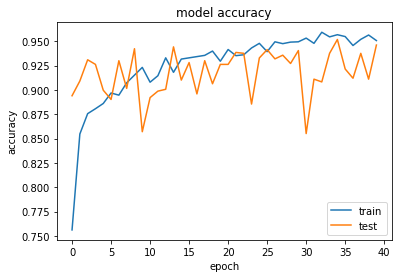

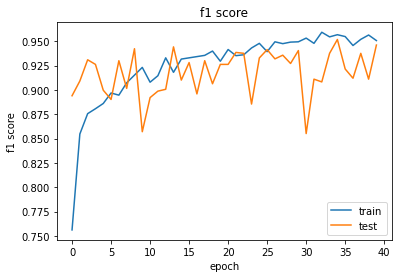

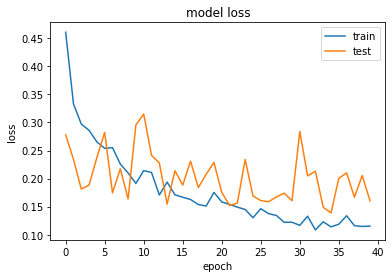

Found 530 images belonging to 3 classes.


In [ ]:
model_path4 ='/content/drive/MyDrive/TFM/VGG16_models/model_VGG16_hyper/'
name = "model_VGG16_Adam_0.01"
model4_history = np.load(model_path4 + '{}-History.npy'.format(name),allow_pickle='TRUE').item()
# model4 = keras.models.load_model(model_path4 + name +"_best.hdf5")
inputs = tf.keras.Input(shape=(224, 224, 3))
head_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

head_model.trainable = True

head_model = head_model(inputs, training = True)
head_model = tf.keras.layers.Flatten()(head_model)
head_model = tf.keras.layers.Dense(256, activation='relu')(head_model)
# output = Dense(2, activation='softmax')(head_model)
output = Dense(3, activation='softmax')(head_model)
model4 = Model(inputs=inputs, outputs = output)
model4.load_weights(model_path4 + "{}_best.hdf5".format(name))
model4.compile(loss="categorical_crossentropy", 
              optimizer=Adagrad(learning_rate=0.0001),
              metrics=[tfa.metrics.F1Score(num_classes=2, average='micro'), 'accuracy'])

# Visualizamos la evolución de la accuracy
plt.plot(model4_history['accuracy'])
plt.plot(model4_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.plot(model4_history['f1_score'])
plt.plot(model4_history['val_f1_score'])
plt.title('f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.plot(model4_history['loss'])
plt.plot(model4_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

test_datagen  = ImageDataGenerator(rescale=1./255)
test_generator =  test_datagen.flow_from_directory('/content/Fold10/Test',
                                                          batch_size=530,
                                                          class_mode  = 'categorical',
                                                          target_size = (224, 224), shuffle=False)

test_lost, test_f1, test_acc = model4.evaluate(test_generator)
print ("Test f1:", test_f1)
print ("Test Accuracy:", test_acc)

test_generator.reset()
predict = model4.predict(test_generator)
y_pred = np.rint(predict)
y_true = test_generator.classes
pred2 = []
for p in y_pred:
  pred2.append(np.argmax(p))

matrix = confusion_matrix(y_true, pred2)
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['Calc', 'Mass', 'Otros'])
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Matriz de confusión")
plt.show()